In [1]:
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig

In [2]:
from transformers import BitsAndBytesConfig

In [3]:
model = LlamaForCausalLM.from_pretrained(
    "baffo32/decapoda-research-llama-7B-hf",
    quantization_config=BitsAndBytesConfig(load_in_8bit=True),
    device_map="auto",
)

The following generation flags are not valid and may be ignored: ['pad_token_id']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [4]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
 

In [5]:
for i, para in enumerate(model.named_parameters()):
    print(f"{i}, \t {para[1].device} \t {para[1].dtype}")

0, 	 cuda:0 	 torch.float16
1, 	 cuda:0 	 torch.int8
2, 	 cuda:0 	 torch.int8
3, 	 cuda:0 	 torch.int8
4, 	 cuda:0 	 torch.int8
5, 	 cuda:0 	 torch.int8
6, 	 cuda:0 	 torch.int8
7, 	 cuda:0 	 torch.int8
8, 	 cuda:0 	 torch.float16
9, 	 cuda:0 	 torch.float16
10, 	 cuda:0 	 torch.int8
11, 	 cuda:0 	 torch.int8
12, 	 cuda:0 	 torch.int8
13, 	 cuda:0 	 torch.int8
14, 	 cuda:0 	 torch.int8
15, 	 cuda:0 	 torch.int8
16, 	 cuda:0 	 torch.int8
17, 	 cuda:0 	 torch.float16
18, 	 cuda:0 	 torch.float16
19, 	 cuda:0 	 torch.int8
20, 	 cuda:0 	 torch.int8
21, 	 cuda:0 	 torch.int8
22, 	 cuda:0 	 torch.int8
23, 	 cuda:0 	 torch.int8
24, 	 cuda:0 	 torch.int8
25, 	 cuda:0 	 torch.int8
26, 	 cuda:0 	 torch.float16
27, 	 cuda:0 	 torch.float16
28, 	 cuda:0 	 torch.int8
29, 	 cuda:0 	 torch.int8
30, 	 cuda:0 	 torch.int8
31, 	 cuda:0 	 torch.int8
32, 	 cuda:0 	 torch.int8
33, 	 cuda:0 	 torch.int8
34, 	 cuda:0 	 torch.int8
35, 	 cuda:0 	 torch.float16
36, 	 cuda:0 	 torch.float16
37, 	 cuda:0 	 torch.

# Toy example

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
class ToyModel(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net1 = nn.Linear(10000, 10).to("cuda:0")
        self.relu = nn.ReLU()
        self.net2 = nn.Linear(10, 5).to("cuda:1")
    
    def forward(self, x):
        x = self.relu(self.net1(x.to("cuda:0")))
        return self.net2(x.to("cuda:1"))

In [8]:
model = ToyModel()

In [9]:
model.relu

ReLU()

In [10]:
type(list(model.net1.parameters())[0])

torch.nn.parameter.Parameter

In [11]:
print(next(model.net1.parameters())[0].device)
print(next(model.net2.parameters())[0].device)

cuda:0
cuda:1


In [12]:
model = ToyModel()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

optimizer.zero_grad()
outputs = model(torch.randn(20, 10000))
labels = torch.randn(20, 5).to("cuda:1")

loss = loss_fn(outputs, labels)
loss.backward()
optimizer.step()

## Split ResNet

In [13]:
from torchvision.models.resnet import ResNet, Bottleneck

In [14]:
model = ResNet(Bottleneck, [3, 4 ,6, 3])

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
t = torch.rand((2, 3, 4))
print(t.shape)

t.view(t.size(0), -1).shape

torch.Size([2, 3, 4])


torch.Size([2, 12])

In [17]:
class ModelParallelResNet50(ResNet):
    
    def __init__(self, num_classes=1000):
        super().__init__(Bottleneck, [3,4,6,3], num_classes=num_classes)
        
        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,
            self.layer1,
            self.layer2,
        ).to("cuda:0")
        
        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        ).to("cuda:1")
        
        self.fc.to('cuda:1')
        
        
    def forward(self, x):
        x = self.seq1(x).to("cuda:1")
        x = self.seq2(x)
        return self.fc(x.view(x.size(0), -1))
    

In [18]:
def model_size(model):
    return sum([para.numel() for para in model.parameters()])

In [19]:
model_size(model)

25557032

In [20]:
mp_model = ModelParallelResNet50()

In [21]:
model_size(model)

25557032

In [22]:
num_classes = 1000

In [23]:
one_hot_indices = torch.LongTensor(5).random_(0, num_classes).view(5, 1)
one_hot_indices

tensor([[498],
        [627],
        [573],
        [931],
        [443]])

In [24]:
labels = torch.zeros(5, num_classes).scatter_(1, one_hot_indices, 1)
labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [25]:
num_batches = 3
batch_size = 120
image_w = 128
image_h = 128

def train(model):
    model.train(True)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-3)
    
    one_hot_indices = torch.LongTensor(batch_size).random_(0, num_classes).view(batch_size, 1)
    
    for _ in range(num_batches):
        # generate random inputs and labels
        # (b, c, w, h)
        inputs = torch.randn(batch_size, 3, image_w, image_h).to("cuda:0")
        labels = torch.zeros(batch_size, num_classes).scatter_(1, one_hot_indices, 1)
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.to(outputs.device)
        loss_fn(outputs, labels).backward()
        optimizer.step()

        

In [26]:
train(mp_model)

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

num_repeat = 10

stmt = "train(model)"

setup = "model = ModelParallelResNet50()"

mp_run_time = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals()
)

mp_mean, mp_std = np.mean(mp_run_time), np.std(mp_run_time)

setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"

rn_run_time = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals()
)

rn_mean, rn_std = np.mean(rn_run_time), np.std(rn_run_time)

In [28]:
def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds, align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel("ResNet50 Execution Time (Second)")
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()
    

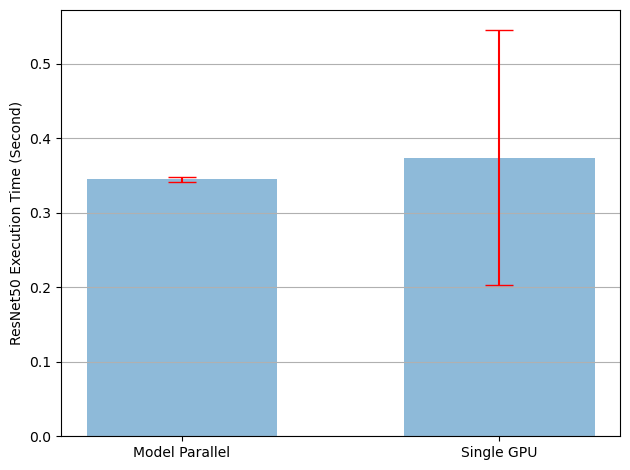

In [29]:
plot([mp_mean, rn_mean], [mp_std, rn_std], ['Model Parallel', 'Single GPU'], 'mp vs rn')